# Single label Classifier - AF Detection

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import sys
sys.path.append("../../tutorials/fastai/old/") # go to parent dir

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import f1_score


Bad key "text.kerning_factor" on line 4 in
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [22]:
df_raw = pd.read_feather('datasets/base/pyhs-raw-corrected')
df_raw

,age,sex,fmax,mean_RR,mean_R_Peaks,mean_T_Peaks,mean_P_Peaks,mean_Q_Peaks,mean_S_Peaks,median_RR,...,var_RR,var_R_Peaks,skew_RR,skew_R_Peaks,kurt_RR,kurt_R_Peaks,mean_P_Onsets,mean_T_Offsets,HRV,label
0,64,1,8.203281,4460.777778,1.906904e+05,84.166667,77.666667,-32.750000,-46.666667,4017.0,...,8.233628e+06,3.074513e+10,0.326896,0.452789,-1.114599,-1.285166,4617.666667,5106.166667,300.261749,PAC
1,24,1,2.150430,9963.953488,1.612913e+05,183.904762,44.047619,-38.190476,-212.047619,9914.0,...,3.436726e+07,1.481045e+10,0.008229,-0.012282,-1.196234,-1.955239,10309.619048,10776.285714,252.051913,Normal
2,59,0,1.054852,7031.666667,2.289459e+05,120.466667,58.733333,-36.200000,-130.266667,6993.0,...,1.704473e+07,4.754209e+10,0.016040,0.102263,-1.178660,-1.859521,6736.266667,7255.600000,247.390310,PAC
3,14,1,7.645041,6695.090909,4.049139e+06,56.714286,57.190476,-148.619048,-121.952381,6660.0,...,1.752821e+07,8.191544e+11,0.031014,-4.325836,-1.220443,16.835113,6795.238095,7248.285714,319.844531,Normal
4,40,1,2.182612,5615.250000,1.302676e+06,196.000000,40.818182,-218.636364,-259.454545,5640.0,...,1.072786e+07,1.682837e+12,-0.014445,0.045967,-1.216803,-1.940233,5709.272727,6233.818182,237.254954,RBBB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6872,61,1,2.200880,5355.391304,6.515502e+05,4.000000,4.600000,-13.800000,-558.100000,5212.0,...,8.467770e+06,5.689022e+11,-0.042738,0.273157,-1.121451,-1.911613,5066.800000,5409.800000,231.441628,AF
6873,78,1,4.201681,5052.095238,2.516323e+06,33.583333,-16.833333,-116.583333,-231.250000,4936.0,...,7.846417e+06,5.001414e+12,-0.059236,-0.246734,-0.964861,-1.885106,4722.000000,5218.000000,254.732016,AF
6874,12,1,1.583861,6097.157895,3.228570e+05,276.333333,30.777778,-94.222222,-266.166667,6134.0,...,1.271993e+07,5.643145e+10,-0.021902,0.088967,-1.201353,-1.860108,6067.111111,6543.000000,160.942494,Normal
6875,59,1,6.102441,5006.153846,7.516309e+05,-15.900000,13.333333,-36.500000,-34.700000,5632.0,...,9.243060e+06,3.005175e+11,-0.216776,-0.494394,-1.168932,-1.662923,NaN,5240.400000,413.754658,I-AVB


In [5]:
df_raw['PT_duration'] = df_raw['mean_T_Offsets'] - df_raw['mean_P_Onsets']
df_raw.drop(['mean_T_Offsets', 'mean_P_Onsets'], axis=1, inplace=True)

In [6]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.177548,0.104988,0.028937,0.133488,0.079104,0.091173,0.243566,0.114294,0.026901
std,0.382160,0.306560,0.167642,0.340127,0.269921,0.287877,0.429265,0.318191,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split between Train and Validation Datasets

### Training Set (80%)

In [7]:
df_af = df_raw[(df_raw.loc[:, 'label'] == 'AF')]
df_af.reset_index(inplace=True)
df_train_af = df_af.sample(frac=0.8)

id_train = list(df_train_af.index)
id_valid = [y for y in range(len(df_af)) if y not in id_train]
df_valid_af = df_af.loc[id_valid,:]
len(df_valid_af), len(df_train_af), len(df_af)

(244, 977, 1221)

### Validation (20%)

In [8]:
df_rest = df_raw[(df_raw.loc[:, 'label'] != 'AF')]
df_rest.reset_index(inplace=True)
df_train_rest = df_rest.sample(n=len(df_train_af))

id_train = list(df_train_rest.index)
id_valid = [y for y in range(len(df_af)) if y not in id_train][:len(df_valid_af)]
df_valid_rest = df_rest.loc[id_valid,:]
len(df_valid_rest), len(df_train_rest), len(df_rest)

(244, 977, 5656)

### We check to see if the labels we sampled in the same proportion as they appear in the original dataset

In [9]:
labels = pd.get_dummies(df_train_rest['label'])
labels.describe()

,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000
mean,0.116684,0.047083,0.181167,0.095189,0.102354,0.289662,0.135107,0.032753
std,0.321207,0.211925,0.385354,0.293627,0.303269,0.453838,0.342013,0.178081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We've seen a variability of ~3% to 5%. Apparently there's a 0.01 to 0.02 of fluctuation in the model's score depending on how the datasets are sampled. We may consider changing the sampling to one that provides more robust and fiable results.

### Renaming everything else as "Non-AF" in both sets

In [10]:
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'I-AVB'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'LBBB'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'Normal'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'PAC'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'PVC'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'RBBB'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'STD'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'STE'] = 'Non-AF'

df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'I-AVB'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'LBBB'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'Normal'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'PAC'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'PVC'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'RBBB'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'STD'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'STE'] = 'Non-AF'


df_train_rest

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

,index,age,sex,fmax,mean_RR,mean_R_Peaks,mean_T_Peaks,mean_P_Peaks,mean_Q_Peaks,mean_S_Peaks,...,std_R_Peaks,var_RR,var_R_Peaks,skew_RR,skew_R_Peaks,kurt_RR,kurt_R_Peaks,HRV,label,PT_duration
1318,1595,26,1,2.633768,7071.368421,1.401063e+06,109.833333,45.277778,-31.833333,-377.444444,...,7.001618e+04,1.841112e+07,5.174614e+09,0.026138,-0.062307,-1.212846,-0.420648,381.019685,Non-AF,436.222222
5089,6175,80,0,3.801521,5042.240000,1.012503e+06,178.750000,9.083333,-158.000000,-191.833333,...,1.021586e+06,8.642156e+06,1.087122e+12,-0.020371,0.109425,-1.211095,-1.950702,205.677032,Non-AF,495.500000
1662,2003,70,0,2.793489,14526.439024,6.047590e+05,275.900000,10.200000,-51.675000,-283.025000,...,6.268728e+04,7.276126e+07,4.027937e+09,-0.004341,0.164156,-1.204505,-1.033500,356.017661,Non-AF,492.900000
4888,5923,51,0,1.100440,5086.142857,1.161937e+06,149.090909,16.636364,-165.727273,-42.818182,...,6.066739e+05,8.764346e+06,3.963650e+11,-0.086625,-1.228447,-1.051492,-0.254885,382.906395,Non-AF,478.727273
4463,5402,58,1,4.557964,5599.222222,6.511400e+05,101.176471,20.235294,-52.705882,-163.941176,...,5.199168e+04,1.223046e+07,2.862142e+09,0.004653,-0.271230,-1.215739,-1.215315,326.208162,Non-AF,448.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5381,6537,61,0,1.470934,8242.352941,3.334332e+05,256.125000,19.687500,-86.812500,-330.000000,...,3.748975e+05,2.645563e+07,1.448072e+11,0.140910,0.652386,-1.260621,-1.473640,281.178742,Non-AF,572.500000
4769,5773,72,0,4.222848,14315.000000,8.355957e+05,42.678571,46.607143,-23.750000,-272.678571,...,6.770720e+05,6.297800e+07,4.681803e+11,-0.155604,-0.337956,-1.154610,-1.770962,313.749256,Non-AF,576.785714
4328,5238,70,1,3.072306,6960.592593,5.030778e+05,7.571429,69.636364,-47.681818,-238.954545,...,2.393374e+05,1.812708e+07,5.948558e+10,0.015002,-1.356954,-1.197953,0.176529,278.500794,Non-AF,NaN
936,1129,37,0,1.562891,7996.193548,1.091186e+06,87.100000,-13.200000,-80.900000,-76.000000,...,8.315748e+05,2.362012e+07,7.145672e+11,0.008232,-0.279507,-1.253010,-1.690040,288.384234,Non-AF,558.400000


### We merge both sets into one

In [11]:
df_train = pd.concat([df_train_af, df_train_rest])
df_valid = pd.concat([df_valid_af, df_valid_rest])
df_train.drop('index', inplace=True, axis=1)
df_valid.drop('index', inplace=True, axis=1)

df_train

,age,sex,fmax,mean_RR,mean_R_Peaks,mean_T_Peaks,mean_P_Peaks,mean_Q_Peaks,mean_S_Peaks,median_RR,...,std_R_Peaks,var_RR,var_R_Peaks,skew_RR,skew_R_Peaks,kurt_RR,kurt_R_Peaks,HRV,label,PT_duration
601,76,1,5.302121,4784.421053,1.108024e+06,27.812500,-11.937500,-28.250000,-67.937500,4780.0,...,481875.587147,9.984826e+06,2.451043e+11,0.033885,-1.788536,-1.338561,1.355093,275.899640,AF,505.000000
824,76,0,1.158139,9752.320000,6.450216e+04,155.782609,-3.208333,-43.625000,-70.958333,9656.0,...,41724.682306,3.018778e+07,1.776479e+09,-0.031232,0.343378,-1.162722,-0.829585,201.271621,AF,NaN
550,61,0,1.600640,5060.400000,2.786069e+04,100.928571,15.857143,-64.857143,-29.857143,5218.0,...,16186.079267,8.768257e+06,2.710233e+08,-0.025552,0.920998,-1.230847,-0.466336,168.584676,AF,503.428571
112,68,1,8.703481,4804.631579,8.372737e+05,6.055556,50.277778,-7.944444,-435.333333,4752.0,...,215251.163301,9.002396e+06,4.890712e+10,0.012962,-2.896753,-1.229992,8.590914,264.042715,AF,424.555556
1153,69,0,2.903173,12557.333333,1.648929e+06,71.203704,20.259259,-43.648148,-93.000000,12426.0,...,633331.897357,4.626030e+07,4.075788e+11,0.056916,-1.106522,-1.202229,0.560346,189.289546,AF,455.703704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5381,61,0,1.470934,8242.352941,3.334332e+05,256.125000,19.687500,-86.812500,-330.000000,7789.0,...,374897.485834,2.645563e+07,1.448072e+11,0.140910,0.652386,-1.260621,-1.473640,281.178742,Non-AF,572.500000
4769,72,0,4.222848,14315.000000,8.355957e+05,42.678571,46.607143,-23.750000,-272.678571,15114.0,...,677072.012582,6.297800e+07,4.681803e+11,-0.155604,-0.337956,-1.154610,-1.770962,313.749256,Non-AF,576.785714
4328,70,1,3.072306,6960.592593,5.030778e+05,7.571429,69.636364,-47.681818,-238.954545,6866.0,...,239337.447243,1.812708e+07,5.948558e+10,0.015002,-1.356954,-1.197953,0.176529,278.500794,Non-AF,NaN
936,37,0,1.562891,7996.193548,1.091186e+06,87.100000,-13.200000,-80.900000,-76.000000,7998.0,...,831574.800703,2.362012e+07,7.145672e+11,0.008232,-0.279507,-1.253010,-1.690040,288.384234,Non-AF,558.400000


In [12]:
df_valid

,age,sex,fmax,mean_RR,mean_R_Peaks,mean_T_Peaks,mean_P_Peaks,mean_Q_Peaks,mean_S_Peaks,median_RR,...,std_R_Peaks,var_RR,var_R_Peaks,skew_RR,skew_R_Peaks,kurt_RR,kurt_R_Peaks,HRV,label,PT_duration
6,74,0,0.722383,9334.645161,4.618444e+05,83.280000,36.240000,-43.000000,-162.640000,9904.0,...,4.394153e+05,3.009217e+07,1.995220e+11,-0.101298,3.925425,-1.236883,17.796291,312.602197,AF,532.560000
7,44,0,0.454876,5349.481481,1.152448e+05,39.937500,7.812500,-37.750000,-75.000000,5136.0,...,9.288538e+04,1.051305e+07,8.959528e+09,0.021882,-0.304953,-1.240005,-1.803908,211.492135,AF,600.125000
13,82,0,0.875146,11875.176471,5.797944e+04,40.516129,12.156250,-29.250000,-31.645161,11174.0,...,4.632924e+04,5.329987e+07,2.189326e+09,0.064535,0.066723,-1.244666,-1.314899,254.668569,AF,NaN
32,52,1,1.500300,9911.673469,4.922529e+04,64.857143,13.321429,-25.642857,-52.750000,9814.0,...,4.269644e+04,3.534778e+07,1.860965e+09,0.016493,1.768328,-1.266093,6.180717,218.666889,AF,597.857143
34,61,0,0.100040,4798.636364,2.115996e+06,25.923077,47.153846,-382.923077,-217.076923,4605.0,...,5.267726e+06,8.298566e+06,2.907032e+13,0.042709,3.403611,-1.152905,10.450679,244.492282,AF,489.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,30,0,1.300520,5119.375000,3.518941e+05,149.166667,3.500000,-40.333333,-229.750000,4854.0,...,1.954562e+05,1.057614e+07,4.075001e+10,0.093064,-1.008138,-1.270595,-0.765231,343.411997,Non-AF,521.666667
292,63,1,1.412049,7189.652174,1.732206e+06,-105.100000,-8.285714,-37.714286,-81.142857,7160.0,...,5.911037e+05,2.022930e+07,3.652855e+11,0.032969,-1.223177,-1.142388,3.358264,338.059704,Non-AF,NaN
293,55,1,0.921829,5578.100000,1.502736e+06,224.100000,22.000000,-41.500000,-294.300000,5564.0,...,1.458552e+06,1.055460e+07,2.239342e+12,0.021631,0.051546,-1.221212,-1.934265,288.356322,Non-AF,577.600000
294,67,0,1.700680,5120.875000,5.743974e+05,-95.250000,466.812500,374.375000,-106.250000,5143.0,...,8.474406e+04,8.125271e+06,7.660326e+09,-0.012885,-0.289989,-1.198333,-0.807907,300.541179,Non-AF,370.500000


## Check to see if training set is balanced between AF and Non-AF

In [13]:
labels = pd.get_dummies(df_train['label'])
labels.describe()

,AF,Non-AF
count,1954.000000,1954.000000
mean,0.500000,0.500000
std,0.500128,0.500128
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.500000,0.500000
75%,1.000000,1.000000
max,1.000000,1.000000


### We process our datasets and train our model

In [23]:
X_train, y_train, nas = proc_df(df_train, 'label')
X_valid, y_valid, nas = proc_df(df_valid, 'label', na_dict=nas)

In [24]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train, y_train)

m_af.score(X_train,y_train), m_af.score(X_valid, y_valid), m_af.oob_score_

CPU times: user 6.84 s, sys: 199 ms, total: 7.04 s
Wall time: 2.23 s


(1.0, 0.8688524590163934, 0.861310133060389)

In [25]:
f1_score(y_valid, m_af.predict(X_valid), average='weighted')

0.8687731092436974

In [26]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

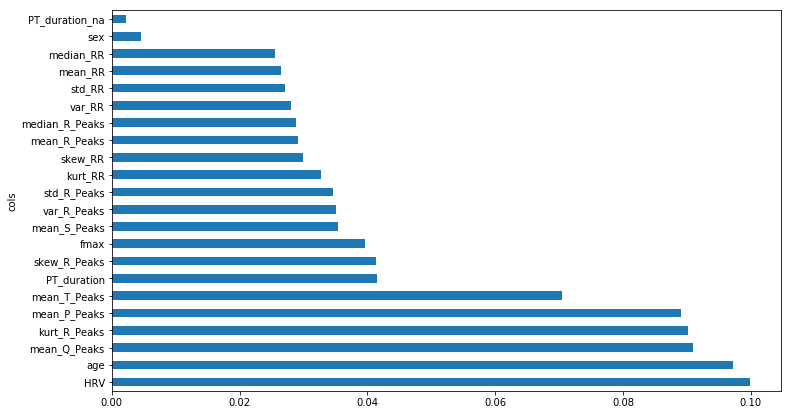

In [27]:
fi_af = rf_feat_importance(m_af, X_train)
plot_fi(fi_af);

In [28]:
to_keep = list(fi_af[fi_af['imp'] > 0.002].cols)

X_train_keep = X_train[to_keep]
X_valid_keep = X_valid[to_keep]

In [29]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_keep, y_train)

m_af.score(X_train_keep, y_train), m_af.score(X_valid_keep, y_valid), m_af.oob_score_

CPU times: user 6.93 s, sys: 181 ms, total: 7.11 s
Wall time: 2.32 s


(1.0, 0.8627049180327869, 0.8633572159672467)

In [30]:
f1_score(y_valid, m_af.predict(X_valid_keep), average='weighted')

0.8626582039208108